# On modelling optimization problems via Julia JuMP

## Prof. Mayron César O. Moreira 

**Universidade Federal de Lavras (UFLA)**  
**Department of Computer Science**  
**Lavras, Minas Gerais, Brazil**  

*Università degli Studi di Modena e Reggio Emilia (UNIMORE)*  
*Reggio Emilia, Italy*

## On solving arc routing in Eulerian districts
 
Consider a company that wants to plan routing activities in a city, for commercial proposals. The company aims at dividing streets into connected districts to avoid overloading of its teams. The number of business areas corresponds to the number of depots the company has. The main goal is to minimize the total distance traveled by workers assigned to its corresponding region, using the depot position as a reference point.

In this notebook, we will work with García-Ayala et al. (2016) paper, that describes a variant of the previous arc routing problem such that the induced subgraph generated by the partitioning process must keep even degree of their vertices, keeping a percentage of Eulerian subgraphs. The idea of having Eulerian subgraphs is to avoid running the same edge twice and then, reduce "*deadhead time*." As follows, we show the **Figure extracted from García-Ayala et al. (2016)**, that shows unfavorable and favorable arc partitions.

![García-Ayala et al. (2016)](images/eulerian.png)

### Mathematical model
We present the mathematical model introduced by García-Ayala et al. (2016).

* **Parameters**
    * $G=(V,E)$: planar graph, $|V|=n$ and $|E|=m$, where $V$ represents street crossings or dead ends, and each edge corresponds to a street or a road.  
    * $e=(i,j) \in E$: each edge $e$ has a length $l_e \in \mathbb{R}_+$, and a demand $d_e \in \mathbb{R}_+$.  
    * $P=\{1,2,...,k\} \subset V$: set of depots.  
    * $\sigma(e)$: set of edges adjacent to $e$.  
    * $\sigma(S) \subset E$: cut set of $S$. The edge $e=(i,j) \in \sigma(S)$ if $i \in V\backslash V(S)$ and $j \in V(S)$, where $V(S)$ is the set of vertices associated with edges on $S$.    
    * $\delta(i) \subset E$: set of edges adjacent to $i \in V$.  
    * $\tilde{V} \subseteq V$: set of even degree vertices.  
    * $b_{pe} \in \mathbb{R}_+$: minimum distance from depot $p$ to edge $e=(i,j)$, given by $b_{pe} = \min\{f_{pi},f_{pj}\}$, where $f_{ij}$ is the shortest-path between $i$ and $j$ on $G$.  
    * $\overline{D} = \frac{\sum_{e \in E}d_e}{|P|}$: average demand per district.  
    * $\tau_1 \in (0,1)$: tolerance for demand balance constraints.  
    * $\tau_2 \in (0,1)$: tolerance for parity balance constraints.  
    * $M \in \mathbb{R}_+$: sufficient large constant. 


* **Solution**: $k$-partition of edges $(E_1,E_2,...,E_k)$ such that each district $(V(E_p),E_p)$ must meet technical criteria (mathematically exposed in the following). We take $V(E_p)$ as the set of vertices that are incident to at least one edge of $E_p$.

* **Parameters (Julia)**

In [28]:
include("codes/instanceAR.jl")

# Arc routing instance
fileInstance="instances/ar/Problem2.txt"

io=open(fileInstance)

instance = readAR(io)

n = instance.n
m = instance.m
k = instance.k
Edges = instance.E
E = Dict()

d = zeros(Float64, m)
for e in Edges
    d[e.id] = e.d
    E[e.i.id,e.j.id] = e.id
end

b = instance.b
sgmE = instance.sgmE # sigma(e)
delta = instance.delta
davg = instance.davg

V = collect(1:n)
P = collect(1:k)


# Sets of even and odd degree vertices
V_Even = [i for i in V if size(delta[i])[1] % 2 == 0]
V_Odd = [i for i in V if size(delta[i])[1] % 2 != 0]
                        
tau1 = 0.10
tau2 = 0.05
                        
M = size(maximum(delta))[1] # M is equal to the largest node degree
; # Disable output messages after the block

* **Drawing the graph**

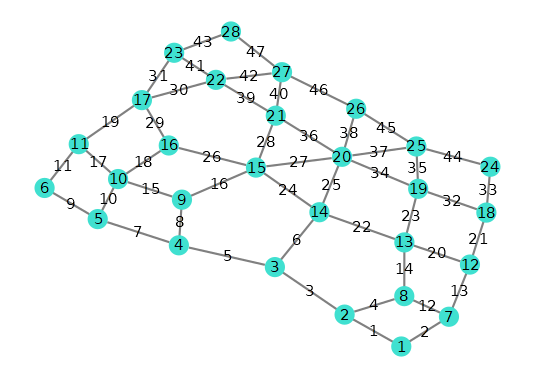

In [29]:
using GraphPlot, LightGraphs, Cairo, Fontconfig, Colors, Compose

g = Graph(n)

edgelabel = Array{Int64}(undef, m)
nodelabel = Array{Int64}(undef, n)

for i in 1:m
    add_edge!(g, Edges[i].i.id, Edges[i].j.id)
    edgelabel[i] = Edges[i].id
end

edgeColor = [colorant"grey", colorant"blue", colorant"orange", colorant"red", colorant"purple", colorant"darkred", colorant"cyan", colorant"magenta", colorant"darkblue", colorant"lightseagreen"]
colors = [colorant"grey" for i in  1:m]

for i in 1:n
    nodelabel[i]=i
end

gplot(g, edgestrokec=colors, edgelabel=edgelabel, nodelabel=nodelabel)

* **OR libraries**

In [30]:
using JuMP
using Cbc

* **Mathematical model**

In [31]:
model = Model(with_optimizer(Cbc.Optimizer,seconds=60))
;

* **Variables**

    * $x_{pe} \in \{0,1\}$: equal to one if edge $e \in E$ is assigned to district $p \in P$.  
    * $w_{pi} \in \{0,1\}$: equal to one if vertex $i \in V$ is incident to an edge assigned to district $p \in P$.  
    * $z^{O}_{ip} \in \{0,1\}$: equal to one if the degree of vertex $i \in V$ in district $p \in P$ is odd.  
    * $z_{ip} \in \mathbb{Z}_+$: auxiliary variable related to variable $z^{O}_{ip}$.  
    * $r_i \in \{0,1\}$: equal to one if vertex $i \in \tilde{V}$ looses parity.

In [32]:
@variable(model, x[P,1:m], Bin)
@variable(model, w[P,V], Bin)
@variable(model, zo[V,P], Bin)
@variable(model, z[V,P] >= 0, Int)
@variable(model, r[V], Bin)
;

* **Objective function**: minimize sum of distances to and from each edge assigned to the depot. With this function, the authors try to obtain compact districts.

\begin{equation}
\min \sum_{p \in P}\sum_{e \in E} b_{pe}x_{pe}
\end{equation}

In [33]:
@objective(model, Min, sum(b[p,e]*x[p,e] for p=1:k, e=1:m))
;

* **Constraint**: each edge must be assigned to a district.

\begin{equation}
\sum_{p \in P}x_{pe} = 1 \quad \forall e \in E
\end{equation}

In [34]:
@constraint(model, [e=1:m], sum(x[p,e] for p in P) == 1)
;

* **Constraint**: district contiguity.

\begin{equation}
\sum_{s \in \sigma(S)} x_{ps} - \sum_{s \in S} x_{ps} \ge x_{pe} - |S| \quad \forall p \in P, \forall e \in E,  S \subset E \backslash \sigma(e)
\end{equation}

Here we have an exponential number of constraints. To cope with that, García-Ayala et al. (2016) eliminate these constraints and solve the model without them. In the sequence, they add iteratively contiguity cuts identified by a BFS on each district. We will see this in this notebook.

* **Constraint**: balance districts within a tolerance $\tau_1$.

\begin{equation}
\sum_{i \in E}d_ex_{pe} \ge (1-\tau_1)\overline{D} \quad \forall p \in P
\end{equation}

\begin{equation}
\sum_{i \in E}d_ex_{pe} \le (1+\tau_1)\overline{D} \quad \forall p \in P
\end{equation}

In [35]:
@constraint(model, [p in P], sum(d[e]*x[p,e] for e=1:m) >= (1-tau1)*davg)
@constraint(model, [p in P], sum(d[e]*x[p,e] for e=1:m) <= (1+tau1)*davg)
# Alternatively
#@constraint(model, [p in P], (1-tau1)*davg <= sum(d[e]*x[p,e] for e in E) <= (1+tau1)*davg)
#
;

* **Constraint**: coupling constraints between variables $x$ and $w$.

\begin{equation}
\sum_{i \in E}\sum_{e \in \delta(i)} x_{pe} \le Mw_{pi} \quad \forall p \in P, \forall i in V
\end{equation}

\begin{equation}
\sum_{i \in E} w_{pi} \le \sum_{e \in \delta(i)} x_{pe} \quad \forall p \in P, \forall i in V
\end{equation}

In [36]:
@constraint(model, [p in P, i in V], sum(x[p,e] for e in delta[i]) <= M*w[p,i])
@constraint(model, [p in P, i in V], w[p,i] <= sum(x[p,e] for e in delta[i]))
;

* **Constraint**: detect if a vertex $i$ has an odd degree in the partition $p$.

\begin{equation}
\sum_{e \in \delta(i)}x_{pe} = 2z_{ip} + z^{O}_{ip} \quad \forall p \in P, \forall i \in V
\end{equation}

In [37]:
@constraint(model, [p in P, i in V], sum(x[p,e] for e in delta[i]) == 2*z[i,p] + zo[i,p])
;

* **Constraint**: limitation of imparity gain.

\begin{equation}
r_i \le \sum_{p \in P} z^{O}_{ip} \quad \forall i \in \tilde{V}
\end{equation}

\begin{equation}
|P|r_i \ge \sum_{p \in P} z^{O}_{ip} \quad \forall i \in V
\end{equation}

\begin{equation}
r_i \le \sum_{p \in P} z^{O}_{ip} - 1 \quad \forall i \in V \backslash \tilde{V}
\end{equation}

\begin{equation}
|P|r_i \ge \sum_{p \in P} z^{O}_{ip} - 1 \quad \forall i \in V \backslash \tilde{V}
\end{equation}

\begin{equation}
\frac{1}{|V|}\sum_{i \in V}r_i \le \tau_2 
\end{equation}

In [38]:
@constraint(model, [i in V_Even], r[i] <= sum(zo[i,p] for p in P))
@constraint(model, [i in V_Even], k*r[i] >= sum(zo[i,p] for p in P))
@constraint(model, [i in V_Odd], r[i] <= sum(zo[i,p] for p in P) - 1)
@constraint(model, [i in V_Odd], k*r[i] >= sum(zo[i,p] for p in P) - 1)
@constraint(model, (1.0/n)*sum(r[i] for i in V) <= tau2)
;

* **Running the model**

In [ ]:
optimize!(model)
;

* **Depth-First Search (DFS) to identify components**

    * Parameters:
        * $(i)$: graph
        * $(ii)$: district id
        * $(iii)$: set of vertices 
        
For further informations, see (*Cormen, T. H., Leiserson, C. E., Rivest, R. L., & Stein, C. (2009). Introduction to algorithms. Chap. 22. MIT press.*)

In [40]:
function DFS(g, p, setVertices)
    visited = [false for _ in V]
    components = Vector{SimpleDiGraph{Int64}}()
    
    for v in setVertices[p]
        if(!visited[v])
            #=
            The function dfs_tree returns a tree, not necessarily a forest.
            =#
            T = dfs_tree(g[p], v) 
            for e in collect(edges(T))
                visited[src(e)] = visited[dst(e)] = true
            end
            push!(components, T)
        end
    end
    
    return components
end

DFS (generic function with 1 method)

* **(i) Obtaining the results, (ii) testing if the districts are connected, and  (iii) obtaining the cuts**

In [ ]:
## Part (i)

startTime = 0
endTime = 120
while(endTime - startTime >= 0)
    # First, we test if the solution respects conectivity.
    vtxSol = [Vector{Int}() for _ in P]
    edgSol = [Vector{Int}() for _ in P]

    # Create subgraphs of districts
    g = [Graph(n) for p in P]

    for p in P
        for e=1:m
            if(JuMP.value(x[p,e]) >= 0.9)
                add_edge!(g[p], Edges[e].i.id, Edges[e].j.id)

                push!(edgSol[p], e)
                i = Edges[e].i.id
                j = Edges[e].j.id

                # Avoiding repeated items
                if(!(i in vtxSol[p]))
                    push!(vtxSol[p], i)
                end
                if(!(j in vtxSol[p]))
                    push!(vtxSol[p], j)
                end
            end
        end

        # For convenience
        vtxSol[p] = sort(vtxSol[p])
    end

    ##########################

    ## Part (ii)

    finish = true
    for p in P
        components = DFS(g, p, vtxSol)
        numberComp = size(components)[1]
        
        # Then we calculate how the sets S and CutSet will be composed
        println("numberComp = ", numberComp)
        
        if(numberComp > 0)
            finish = false
            # Get the set S
            for c1 in components
                S = Vector{Int}()
                VtxS = Vector{Int}()
                CutSet = Vector{Int}()
            
                edgs = collect(edges(c1))

                for e in edgs
                    if(src(e) < dst(e))
                        push!(S, E[src(e), dst(e)])
                    else
                        push!(S, E[dst(e), src(e)])
                    end
                    
                    if(!(src(e) in VtxS))
                        push!(VtxS, src(e))
                    end
                    
                    if(!(dst(e) in VtxS))
                        push!(VtxS, dst(e))
                    end
                        
                end
                               
                # Calculating CutSet
                for v in VtxS
                    edgs = delta[v] # All edges incident in v
                    for e in edgs
                        if(!(Edges[e].i.id in VtxS && Edges[e].j.id in VtxS))
                            push!(CutSet, e)
                        end
                    end
                end
                
                @constraint(model, sum(x[p,s] for s in CutSet) 
                    - sum(x[p,s] for s in S) >= -1*(size(S)[1] - 1))
            end
        end
    end
    
    if(finish)
        break
    end
    
    # Running model again
    optimize!(model)
    
    startTime = time()
end

* **Printing the graph**

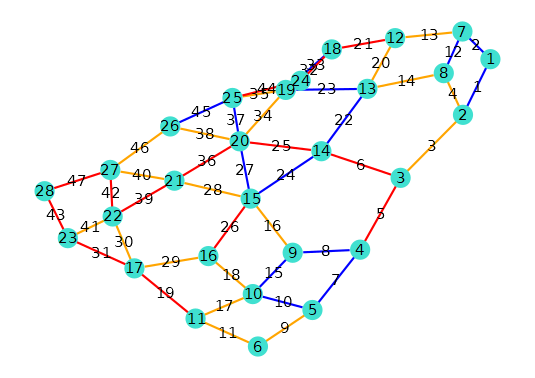

In [43]:
g = Graph(n)

edgelabel = Array{Int64}(undef, m)
nodelabel = Array{Int64}(undef, n)

for i in 1:m
    add_edge!(g, Edges[i].i.id, Edges[i].j.id)
    edgelabel[i] = Edges[i].id
end

edgeColor = [colorant"grey", colorant"blue", colorant"orange", colorant"red", colorant"purple", colorant"darkred", colorant"cyan", colorant"magenta", colorant"darkblue", colorant"lightseagreen"]
colors = [colorant"grey" for i in  1:m]

edgesByDistrict = Vector{Vector{Int}}()
for p=1:k
    vectorAux = Vector{Int}()
    for e=1:m
        if(JuMP.value(x[p,e]) >= 0.9)
            push!(vectorAux, e)
        end
    end
    push!(edgesByDistrict, vectorAux)
end

for p in 1:k
    for j in 1:size(edgesByDistrict[p])[1]
        colors[edgesByDistrict[p][j]] = edgeColor[p + 1]
    end
end

for i in 1:n
    nodelabel[i]=i
end

draw(PNG("Grafo1.png", 20cm, 20cm), 
    gplot(g, edgestrokec=colors, edgelabel=edgelabel, nodelabel=nodelabel))
gplot(g, edgestrokec=colors, edgelabel=edgelabel, nodelabel=nodelabel)

We could also implement this algorithm using *lazy constraints* through *callbacks*, to eliminate disconnected districts. To see an example of how this approach works in JuMP 0.18, see http://www.juliaopt.org/JuMP.jl/v0.12/callbacks.html.

## References

García‐Ayala, G., González‐Velarde, J. L., Ríos‐Mercado, R. Z., & Fernández, E. (2016). A novel model for arc territory design: promoting Eulerian districts. International Transactions in Operational Research, 23(3), 433-458.